In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading
import mediapipe as mp
from matplotlib import pyplot as plt
from IPython.display import clear_output

import time
%matplotlib inline

mp.solutions.drawing_utils._VISIBILITY_THRESHOLD = 0.01
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [3]:
landmark_lb = [ "Elbow(L)", "Elbow(R)", "Shoulder(L)", "Shoulder(R)",  "Hip(L)", "Hip(R)", "Knee(L)", "Knee(R)", "FOOT(L)", "FOOT(R)", "NECK(H)", "NECK(V)"]

z_scale_factor = np.array([ 1, 
                           1, 1, 1, 1, 1, 
                           1, 1, 1, 1, 1, 
                           0.2, 0.2, 0.2, 0.2, 0.2, 
                           0.2, 1, 1, 1, 1, 
                           1, 1, 0.5, 0.5, 0.5, 
                           0.5, 0.5, 0.5, 1, 1, 
                           0.5, 0.5])

def get_angle(a, b, c):
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

def get_joint_angle(data):
    
    joints = [ [11, 13, 15], [12, 14, 16], [12, 11, 13], [11, 12, 14], 
              [11, 23, 25], [12, 24, 26], [23, 25, 27], [24, 26, 28],
              [27,31, 33], [28, 32,34], [8, 35,36], [8, 37, 35] ]
    
    return np.array([ get_angle( *data[j, :3]) for j in joints])

def check_angle(ref_angle, input_angle, thre):
    
    for r, i, t in zip(ref_angle, input_angle, thre):
        if np.abs(r - i) > t:
            break
    else:
        return ref_angle - input_angle
    
    return None

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth[box_pts:-box_pts]


In [5]:

# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', 
    tooltip='Description',
    icon='square' 
)

# Display function
# ================
def view(button):
    #카메라 사용시
    #cap = cv2.VideoCapture(0)
    #비디오 사용시
    cap = cv2.VideoCapture('./video/strength/shoulder_press.mp4')
    #cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    #cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    display_handle=display(None, display_id=True)
    
    target_id = 0
    target_prev_time = time.time()
    error_list = []
    
    coords = np.zeros((1, 38,4))

    score = 0
    cnt = 0

    res = [0]*14 
    
    fig, axs = plt.subplots(1, 1, figsize=(5,5))

    with mp_pose.Pose(
            static_image_mode=False,
            model_complexity=2,
            enable_segmentation=False) as pose:
    
        while True:
            
            _, frame = cap.read()
            image_height, image_width, _ = frame.shape
            results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            
            frame = cv2.flip(frame, 1) # if your camera reverses your image

            if results.pose_landmarks is None:
                continue

            if stopButton.value==True:
                cap.release()
                
            cur_coord = np.array([(results.pose_landmarks.landmark[i].x, 
                              results.pose_landmarks.landmark[i].y, 
                              results.pose_landmarks.landmark[i].z, 
                              results.pose_landmarks.landmark[i].visibility) for i in range(33)])
            
            cur_coord[:, 2] = cur_coord[:, 2] * z_scale_factor
            
            cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[31:32, :2], cur_coord[27:28, 2:], axis=0), (-1,4)), axis= 0)
            cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[32:33, :2], cur_coord[28:29, 2:], axis=0), (-1,4)), axis= 0)
            cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[7:8, :2], cur_coord[8:9, 2:], axis=0), (-1,4)), axis= 0)
            cur_coord = np.append( cur_coord, np.reshape([ cur_coord[8, 0], cur_coord[7, 1], cur_coord[8, 2], cur_coord[8, 3]], (-1,4)), axis= 0)
            cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[0:1, :2], cur_coord[8:9, 2:], axis=0), (-1,4)), axis= 0)
            
            coords = np.append(coords[-2:], np.reshape(cur_coord, (-1,38,4)), axis=0)
            
            coord = np.median(coords, axis =0 )
                       
            input_angles = get_joint_angle(coord)
            
            axs.clear()
            axs.set_xlim(0, 180)
            axs.set_xticks([0, 30, 60, 90, 120, 150, 180])

            axs.barh(np.arange(len(input_angles)), input_angles)
            axs.set_yticks(np.arange(len(input_angles)), labels=landmark_lb)
            fig.tight_layout()

            plt.savefig('test.jpg')
            
            plot = cv2.imread('test.jpg')
            plot = cv2.resize(plot, dsize=(1080, 480))
            frame = cv2.resize(frame, dsize=(640, 1080 ))

            out = np.ones((1080, 640+1080, 3), dtype='uint8') * 255
            
            out[:, :640, :] = frame
            out[:, 640:, :] = plot

            _, out = cv2.imencode('.jpeg', out)
            display_handle.update(Image(data=out.tobytes()))
                
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()



ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

<Figure size 432x288 with 0 Axes>

None

Exception in thread Thread-8 (view):
Traceback (most recent call last):
  File "/Users/ihana/anaconda3/envs/drax/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/Users/ihana/anaconda3/envs/drax/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/k5/lpdkdrrd6vqb4hghjycpv3qw0000gn/T/ipykernel_13539/357082397.py", line 97, in view
ValueError: could not broadcast input array from shape (480,1080,3) into shape (1080,1080,3)


In [ ]:

# Stop button
# ================
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', 
    tooltip='Description',
    icon='square' 
)

# Display function
# ================
def view(button):
    #카메라 사용시
    #cap = cv2.VideoCapture(0)
    #비디오 사용시
    cap = cv2.VideoCapture('./video/strength/shoulder_press.mp4')
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    display_handle=display(None, display_id=True)
    
    target_id = 0
    target_prev_time = time.time()
    error_list = []
    
    coords = np.zeros((1, 38,4))

    score = 0
    cnt = 0

    res = [0]*14 
    
    fig, axs = plt.subplots(1, 1, figsize=(5,5))

    with mp_pose.Pose(
            static_image_mode=False,
            model_complexity=2,
            enable_segmentation=False) as pose:
    
        while True:
            
            _, frame = cap.read()
            image_height, image_width, _ = frame.shape
            results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
            
            frame = cv2.flip(frame, 1) # if your camera reverses your image

            if results.pose_landmarks is None:
                continue
                
            if results.pose_landmarks is None:
                continue

            if stopButton.value==True:
                cap.release()
                
            cur_coord = np.array([(results.pose_landmarks.landmark[i].x, 
                              results.pose_landmarks.landmark[i].y, 
                              results.pose_landmarks.landmark[i].z, 
                              results.pose_landmarks.landmark[i].visibility) for i in range(33)])
            
            cur_coord[:, 2] = cur_coord[:, 2] * z_scale_factor
            
            cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[31:32, :2], cur_coord[27:28, 2:], axis=0), (-1,4)), axis= 0)
            cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[32:33, :2], cur_coord[28:29, 2:], axis=0), (-1,4)), axis= 0)
            cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[7:8, :2], cur_coord[8:9, 2:], axis=0), (-1,4)), axis= 0)
            cur_coord = np.append( cur_coord, np.reshape([ cur_coord[8, 0], cur_coord[7, 1], cur_coord[8, 2], cur_coord[8, 3]], (-1,4)), axis= 0)
            cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[0:1, :2], cur_coord[8:9, 2:], axis=0), (-1,4)), axis= 0)
            
            coords = np.append(coords[-2:], np.reshape(cur_coord, (-1,38,4)), axis=0)
            
            coord = np.median(coords, axis =0 )
                       
            input_angles = get_joint_angle(coord)
            
            print(input_angles)
            
            axs.clear()
            axs.set_xlim(0, 180)
            axs.set_xticks([0, 30, 60, 90, 120, 150, 180])

            axs.barh(np.arange(len(input_angles)), input_angles)
            axs.set_yticks(np.arange(len(input_angles)), labels=landmark_lb)
            fig.tight_layout()

            plt.savefig('test.jpg')
            
            plot = cv2.imread('test.jpg')
            plot = cv2.resize(plot, dsize=(1080, 480))
            frame = cv2.resize(frame, dsize=(640, 1080 ))

            out = np.ones((1080, 640+1080, 3), dtype='uint8') * 255
            
            out[:, :640, :] = frame
            out[:, 640:, :] = plot

            _, out = cv2.imencode('.jpeg', out)
            display_handle.update(Image(data=out.tobytes()))
                
# ================
display(stopButton)
display(angleButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()




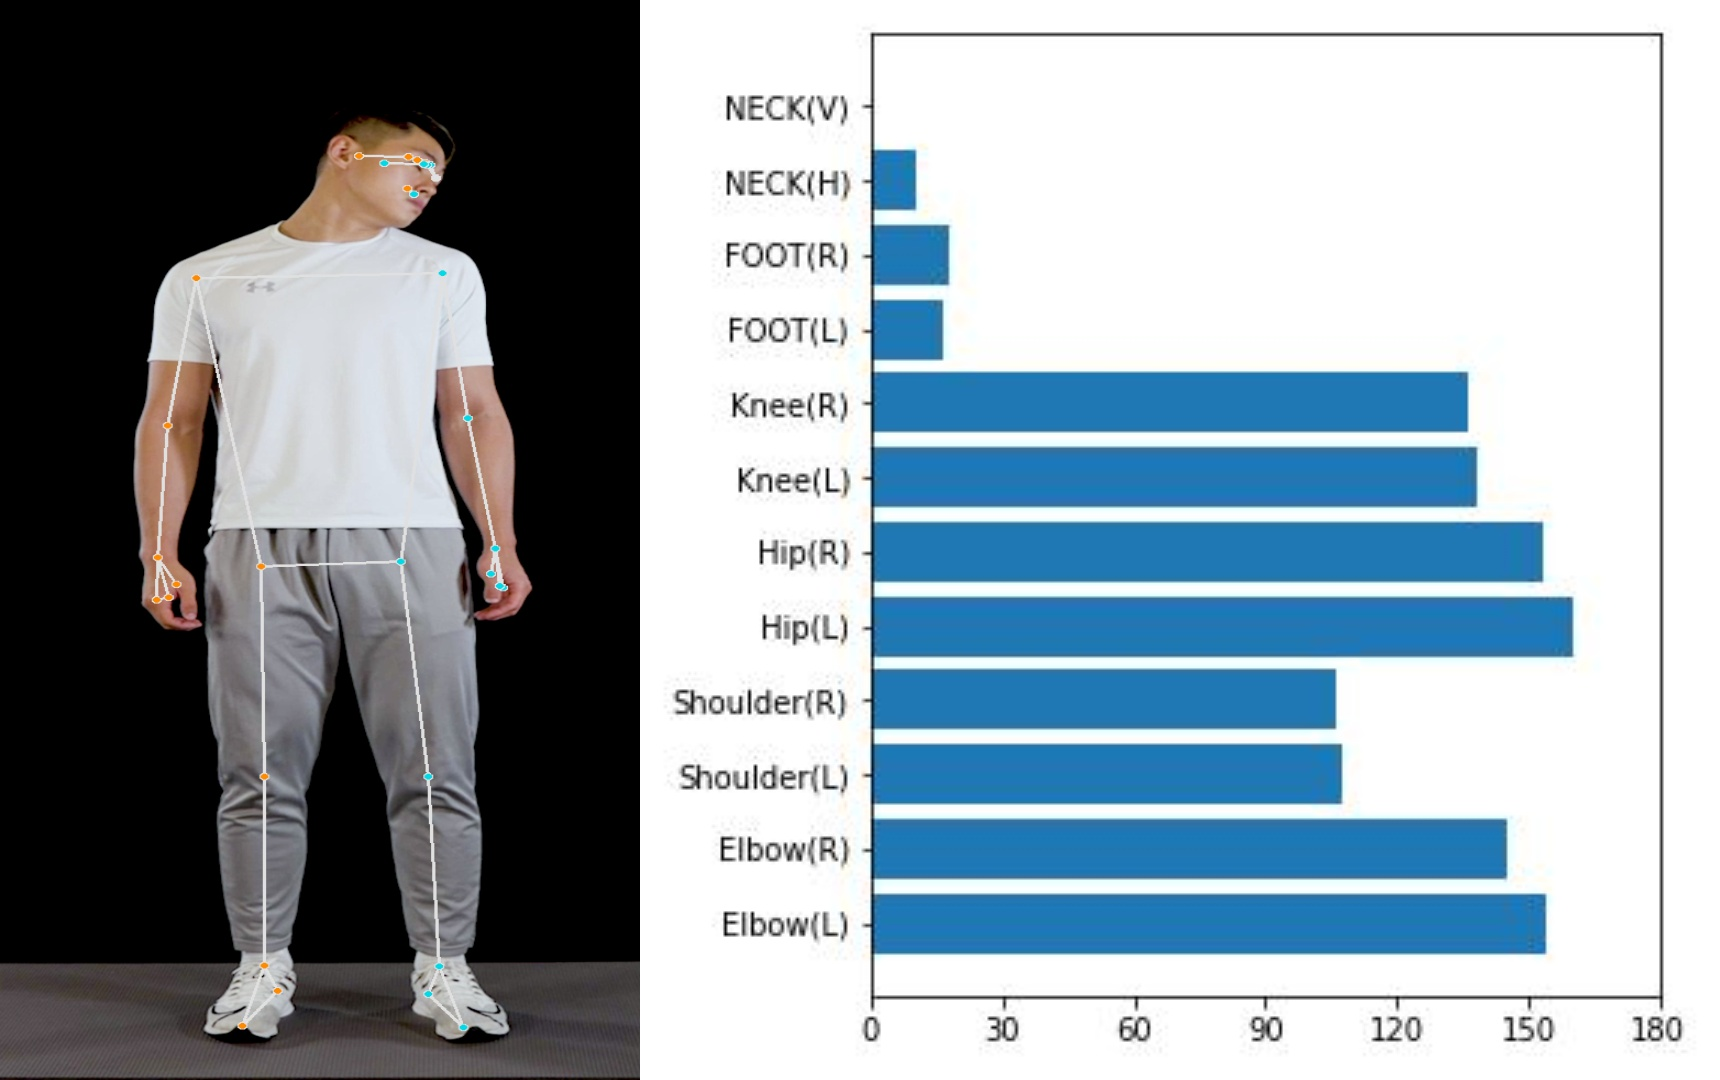

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[154.30247881 145.38826516 107.86012613 106.28113738 160.35779055
 153.72644292 138.16148848 136.46332541  16.1938174   18.17075184
  10.1591341    0.21246231]
['Elbow(L)', 'Elbow(R)', 'Shoulder(L)', 'Shoulder(R)', 'Hip(L)', 'Hip(R)', 'Knee(L)', 'Knee(R)', 'FOOT(L)', 'FOOT(R)', 'NECK(H)', 'NECK(V)']


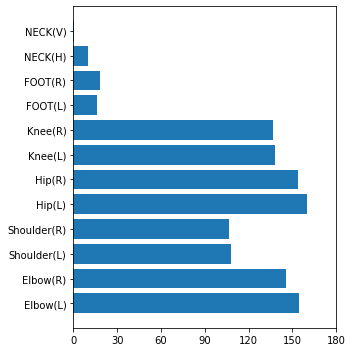

In [4]:
img = cv2.imread("./video/stretch/neck_circum_3.png")
#가로 짧은 버전
#resize_img = cv2.resize(img, (640, 1080))
#가로 긴 버전
resize_img = cv2.resize(img, (1080, 1080))

display_handle=display(None, display_id=True)

target_id = 0
target_prev_time = time.time()
error_list = []

coords = np.zeros((1, 38,4))

score = 0
cnt = 0

res = [0]*14 

fig, axs = plt.subplots(1, 1, figsize=(5,5))

with mp_pose.Pose(
        static_image_mode=False,
        model_complexity=2,
        enable_segmentation=False) as pose:

    frame = img
    image_height, image_width, _ = frame.shape
    results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    mp_drawing.draw_landmarks(
        frame,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    frame = cv2.flip(frame, 1) # if your camera reverses your image


    cur_coord = np.array([(results.pose_landmarks.landmark[i].x, 
                      results.pose_landmarks.landmark[i].y, 
                      results.pose_landmarks.landmark[i].z, 
                      results.pose_landmarks.landmark[i].visibility) for i in range(33)])

    cur_coord[:, 2] = cur_coord[:, 2] * z_scale_factor

    cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[31:32, :2], cur_coord[27:28, 2:], axis=0), (-1,4)), axis= 0)
    cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[32:33, :2], cur_coord[28:29, 2:], axis=0), (-1,4)), axis= 0)
    cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[7:8, :2], cur_coord[8:9, 2:], axis=0), (-1,4)), axis= 0)
    cur_coord = np.append( cur_coord, np.reshape([ cur_coord[8, 0], cur_coord[7, 1], cur_coord[8, 2], cur_coord[8, 3]], (-1,4)), axis= 0)
    cur_coord = np.append( cur_coord, np.reshape(np.append(cur_coord[0:1, :2], cur_coord[8:9, 2:], axis=0), (-1,4)), axis= 0)

    coords = np.append(coords[-2:], np.reshape(cur_coord, (-1,38,4)), axis=0)

    coord = np.median(coords, axis =0 )

    input_angles = get_joint_angle(coord)


    axs.clear()
    axs.set_xlim(0, 180)
    axs.set_xticks([0, 30, 60, 90, 120, 150, 180])

    axs.barh(np.arange(len(input_angles)), input_angles)
    axs.set_yticks(np.arange(len(input_angles)), labels=landmark_lb)
    
    print(input_angles)
    print(landmark_lb)
    fig.tight_layout()

    plt.savefig('test.jpg')

    plot = cv2.imread('test.jpg')
    #가로 짧은 버전
    plot = cv2.resize(plot, dsize=(1080, 1080))
    frame = cv2.resize(frame, dsize=(640, 1080 ))
    #가로 긴 버전
    plot = cv2.resize(plot, dsize=(1080, 1080))
    frame = cv2.resize(frame, dsize=(640, 1080 ))
    #가로 짧은 버전
    out = np.ones((1080, 640+1080, 3), dtype='uint8') * 255
    #가로 긴 버전
    out = np.ones((1080, 640+1080, 3), dtype='uint8') * 255
    #가로 짧은 버전
    out[:, :640, :] = frame
    out[:, 640:, :] = plot
    #가로 긴 버전
    out[:, :640, :] = frame
    out[:, 640:, :] = plot

    _, out = cv2.imencode('.jpeg', out)
    display_handle.update(Image(data=out.tobytes()))